## DSNT

In [1]:
import numpy as np
import tensorflow as tf
import keras
import keras.layers as layers

import Spartan.models as models

In [32]:
import importlib

importlib.reload(models)

def slr_s1_model(height=176, width=176, depth=48, points_num=2, batch_size=2):
    """
    This is a simplified slr model used to debug the original one.
    """
    inputs = keras.Input((height, width, depth, 1))
    # e.x. batches*170*170*30*4*3, 4 type of coordinates, 3 dimensions
    # base_coordinate_xyz = keras.Input((width, height, depth, 4, 3))

    base_cor_rcs = models.coordinate_3d(batch_size, points_num, height, width, depth)

    # x = layers.BatchNormalization()(inputs)
    # x = layers.ReLU()(x)
    #
    # # Stage 1
    # violet_x = models.residual_block(x, downsample=True, filters=4)
    #
    # x = models.residual_block(violet_x, downsample=False, filters=4)
    # violet_x = layers.Add()([x, violet_x])
    #
    # x = models.residual_block(violet_x, downsample=False, filters=4)
    # grey_x_s1 = layers.UpSampling3D(size=2)(x)

    # heatmap_s1 = models.residual_block(grey_x_s1, downsample=False, filters=points_num)
    heatmap_s1 = inputs

    # add dropout?
    # heatmap_s1 = layers.Dropout(0.2)(heatmap_s1)

    pro_matrix_s1 = layers.Reshape((height, width, depth, points_num, 3)) \
        (tf.repeat(layers.Softmax(axis=[1, 2, 3], name="stage1_softmax")(heatmap_s1), repeats=3, axis=-1))
    outputs_s1 = tf.math.reduce_sum(layers.multiply([base_cor_rcs, pro_matrix_s1]), axis=[1, 2, 3])

    model_s1 = keras.Model(inputs, [outputs_s1, pro_matrix_s1], name="slr_stage1")


    return model_s1

In [33]:
batch_size = 2
points_num = 1
height = 5
width = 4
depth = 3

In [34]:
model = slr_s1_model(height, width, depth, points_num, batch_size)
model.summary()

Model: "slr_stage1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 4, 3, 1)]      0         
                                                                 
 stage1_softmax (Softmax)    (None, 5, 4, 3, 1)        0         
                                                                 
 tf.repeat_4 (TFOpLambda)    (None, 5, 4, 3, 3)        0         
                                                                 
 reshape_4 (Reshape)         (None, 5, 4, 3, 1, 3)     0         
                                                                 
 multiply_4 (Multiply)       (2, 5, 4, 3, 1, 3)        0         
                                                                 
 tf.math.reduce_sum_2 (TFOpL  (2, 1, 3)                0         
 ambda)                                                          
                                                        

In [44]:
base_cor_rcs = models.coordinate_3d(batch_size, points_num, height, width, depth)
print(base_cor_rcs[0, :,:,1, 0, 2])
#print(base_cor_rcs[0, :,:,1, 0, 1])
# print(base_cor_rcs[0, :,:,1, 0, :])

[[0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]]


In [38]:
data_bitch = np.ones((batch_size, height, width, depth, 1)) * -1
data_bitch[0, 0, 0, 1, 0] = 10
data_bitch[1, 0, 0, 0, 0] = 10

In [39]:
print(data_bitch[0, :, :, 1, 0])
# print(data_bitch[0, :, :, 1, 0])

[[10. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]


In [40]:
[output, p] = model(data_bitch)
print(output)

tf.Tensor(
[[[-0.99849796  2.4979973   0.5       ]]

 [[-0.99849796  2.4979973  -0.49899864]]], shape=(2, 1, 3), dtype=float32)


In [8]:
print(p[0, :, :, 0, 0, 0])
print(p[0, :, :, 1, 0, 0])

In [46]:
## Heatmap regularization

import numpy as np

def np_bivariate_normal_pdf(domain, mean, variance):
    X = np.arange(-domain+mean, domain+mean, variance)
    Y = np.arange(-domain+mean, domain+mean, variance)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = ((1. / np.sqrt(2 * np.pi)) * np.exp(-.5*R**2))
    return X+mean, Y+mean, Z


In [50]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plt_plot_bivariate_normal_pdf(x, y, z, name):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(x, y, z,
                    cmap=cm.coolwarm,
                    linewidth=0,
                    antialiased=True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z');
    plt.show()

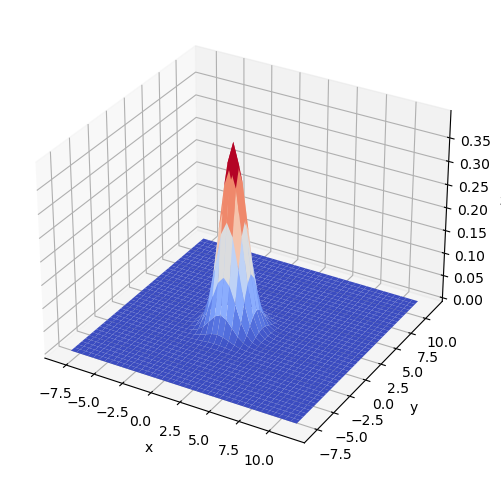

In [52]:
X, Y, Z = np_bivariate_normal_pdf(10, 1, 0.5)

plt_plot_bivariate_normal_pdf(X, Y, Z, "np_5_1_0.5")

## SLR

In [20]:
import tensorflow as tf
import Spartan.models as models

x = tf.ones((2,27,25,25,3))
y = models.residual_block(x, True, 5, 3)

In [24]:
import Spartan.models as models
import importlib

importlib.reload(models)

slr_model = models.slr_model(100,100,100,2,2)
slr_model.summary()

In [25]:
import tensorflow as tf
import Spartan.models as models

x_input = tf.ones((2,100,100,100,1))
[h1, h2] = slr_model(x_input)

In [26]:
y_pred_s1 = models.dsnt_transfer(h1, 2, "stage_1_dsnt")

## U-Net

In [95]:
import Spartan.models as models
import importlib

importlib.reload(models)

u_net_model = models.u_net_model(100,100,100,1)
u_net_model.summary()

## SCN model

In [16]:
import Spartan.models as models
import importlib

importlib.reload(models)

scn_model = models.scn_model(100,100,100,2)
scn_model.summary()